In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

In [2]:
def parse_time(x):
    '''
        Convert unix time to informative time array
        Input: unix time 
        Output: dt.year, dt.month, dt.day, dt.hour, dt.weekday()
    '''
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second, dt.weekday()

def polyline_to_trip_duration(polyline):
    '''
        Convert polyline to time duration
    '''
    return max(polyline.count("[") - 2, 0) * 15

def visualize_data(Xs, ys, title=""):
    plt.figure(figsize=(12,9))
    plt.axhline(color="red")
    plt.axvline(color="red")
    for points_idx, (X, y) in enumerate(zip(Xs, ys)):
        plt.scatter(X, y, s=10, c=colors[points_idx])
    if title:
        plt.title(title, fontsize=24)
    plt.xlabel("X", fontsize=18)
    plt.ylabel("Y", fontsize=18)
    
def expandTaxiStand(x):
    stand_name, stand_lat, stand_lng = taxiStand_to_geo[x["ORIGIN_STAND"]]
    return stand_name, stand_lat, stand_lng

def unstandardize_data(standardized_data, original_mean, original_std):
    original_data = [(value * original_std) + original_mean for value in standardized_data]
    return original_data

In [27]:
# #  Geo data
# df_taxiStand = pd.read_csv("dataset/metaData_taxistandsID_name_GPSlocation.csv")
# # convert the meta information to dict
# taxiStand_to_geo = {0:("None", 0, 0)}
# for _, row in df_taxiStand.iterrows():
#     # taxiStand_to_geo[id] = (stand name, lat, lng)
#     taxiStand_to_geo[row[0]] = (row[1], float(row[2]), float(row[3]))
    

# # Read data and select some columns
# # We currently select not all columns
# df_train = pd.read_csv("dataset/train.csv")
# df_train = df_train.fillna(0)
# df_train[["YR", "MON", "DAY", "HR", "MIN", "SEC","WK"]] = df_train[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
# df_train["TIME_DURATION"] = df_train["POLYLINE"].apply(polyline_to_trip_duration)
# df_train = pd.get_dummies(df_train, columns = ['CALL_TYPE'])
# df_train = df_train.drop(['DAY_TYPE', 'TIMESTAMP'], axis=1)
# df_train[["STAND_NAME", "STAND_LAT", "STAND_LNG"]] = df_train[["ORIGIN_STAND"]].apply(expandTaxiStand, axis=1, result_type="expand")
# df_train = df_train.drop_duplicates()

# # shuffle and select out the validation set
# df_train_sub = df_train.sample(frac=1.0)
# train_valid_cutoff = 1000
# df_valid = df_train_sub[0:train_valid_cutoff].copy()
# df_train = df_train_sub[train_valid_cutoff:].copy()


# # loading the testset
# df_test = pd.read_csv("dataset/test_public.csv")
# df_test = df_test.fillna(0)
# df_test[["YR", "MON", "DAY", "HR", "MIN", "SEC","WK"]] = df_test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
# df_test = pd.get_dummies(df_test, columns = ['CALL_TYPE'])
# df_test = df_test.drop(['DAY_TYPE', 'TIMESTAMP'], axis=1)
# df_test[["STAND_NAME", "STAND_LAT", "STAND_LNG"]] = df_test[["ORIGIN_STAND"]].apply(expandTaxiStand, axis=1, result_type="expand")



In [28]:
# ##
# # global dictionaries for mapping id to index
# from collections import defaultdict

# # Taxi ID
# taxiId = sorted(list(set(df_train["TAXI_ID"].unique())))
# taxiId_to_ix = defaultdict(lambda: 0, { id:i+1 for i,id in enumerate(taxiId)})
# ix_to_taxiId = { i+1:id for i,id in enumerate(taxiId)}

# df_train["TAXI_ID_ix"] = df_train["TAXI_ID"].apply(lambda x : taxiId_to_ix[x])
# df_test["TAXI_ID_ix"] = df_test["TAXI_ID"].apply(lambda x : taxiId_to_ix[x])
# df_valid["TAXI_ID_ix"] = df_valid["TAXI_ID"].apply(lambda x : taxiId_to_ix[x])

# # Call ID
# callId = sorted(list(set(df_train["ORIGIN_CALL"].unique())))[1:] # remove 0 in the first
# callId_to_ix = defaultdict(lambda: 0, { id:i+1 for i,id in enumerate(callId)})
# ix_to_callId = { i+1:id for i,id in enumerate(callId)}

# df_train["CALL_ID_ix"] = df_train["ORIGIN_CALL"].apply(lambda x : callId_to_ix[x])
# df_test["CALL_ID_ix"] = df_test["ORIGIN_CALL"].apply(lambda x : callId_to_ix[x])
# df_valid["CALL_ID_ix"] = df_valid["ORIGIN_CALL"].apply(lambda x : callId_to_ix[x])

In [29]:
# advanced preprocessing to find out 60k representive data
# 17: 40%, 8:10% 3:10%, 14:10% 24000
# bool_17 = df_train["HR"] == 17
# bool_8 = df_train["HR"] == 8
# bool_3 = df_train["HR"] == 3
# bool_14 = df_train["HR"] == 14

# df_hr_17 = df_train[bool_17].sample(n = 18000)
# df_hr_8 = df_train[bool_8].sample(n = 9000)
# df_hr_3 = df_train[bool_3].sample(n = 8000)
# df_hr_14 = df_train[bool_14].sample(n = 8000)
# df_hr_others = df_train[~bool_17 &  ~bool_8 & ~bool_3 & ~bool_14].sample(n = 17000)
                    
# df_subTrain = pd.concat([df_hr_17, df_hr_8, df_hr_3,df_hr_14, df_hr_others])
# df_train = df_subTrain.copy()

In [30]:
# #save df_train and df_valid for thurther load
# df_train.to_csv('final/dataframe/df_train_new.csv', index=False)
# df_valid.to_csv('final/dataframe/df_valid.csv', index=False)
# df_test.to_csv('final/dataframe/df_test.csv', index=False)

In [3]:
# qucik load without processing again
df_train = pd.read_csv("final/dataframe/df_train.csv")
df_valid = pd.read_csv("final/dataframe/df_valid.csv")
df_test = pd.read_csv("final/dataframe/df_test.csv")

In [4]:
# Standardize time duration
time_mean = df_train['TIME_DURATION'].mean()
time_std = df_train['TIME_DURATION'].std()

df_train['TIME_DURATION_STD'] = (df_train['TIME_DURATION'] - df_train['TIME_DURATION'].mean()) / df_train['TIME_DURATION'].std()

# Standardize LAT/lng duration
df_train['LAT_STD'] = (df_train['STAND_LAT'] - df_train['STAND_LAT'].mean()) / df_train['STAND_LAT'].std()
df_train['LNG_STD'] = (df_train['STAND_LNG'] - df_train['STAND_LNG'].mean()) / df_train['STAND_LNG'].std()

# Standardize test
df_test['TIME_DURATION_STD'] = (df_train['TIME_DURATION'] - df_train['TIME_DURATION'].mean()) / df_train['TIME_DURATION'].std()
df_test['LAT_STD'] = (df_test['STAND_LAT'] - df_train['STAND_LAT'].mean()) / df_train['STAND_LAT'].std()
df_test['LNG_STD'] = (df_test['STAND_LNG'] - df_train['STAND_LNG'].mean()) / df_train['STAND_LNG'].std()

# Standardize valid
df_valid['TIME_DURATION_STD'] = (df_valid['TIME_DURATION'] - df_train['TIME_DURATION'].mean()) / df_train['TIME_DURATION'].std()
df_valid['LAT_STD'] = (df_valid['STAND_LAT'] - df_train['STAND_LAT'].mean()) / df_train['STAND_LAT'].std()
df_valid['LNG_STD'] = (df_valid['STAND_LNG'] - df_train['STAND_LNG'].mean()) / df_train['STAND_LNG'].std()

In [5]:
feature_columns = ['MON','HR', 'WK', 'ORIGIN_STAND',"MIN",'SEC', 'CALL_TYPE_A', 'CALL_TYPE_B', 
                   'CALL_TYPE_C']


df_features = df_train[feature_columns].copy()
df_features["ORIGIN_STAND"] = df_features['ORIGIN_STAND'].astype(int)
# concatenate the time-duration column
df_features = pd.concat([df_features, df_train['TIME_DURATION_STD']], axis = 1)

# df_features_test
df_features_test = df_test[feature_columns].copy()
df_features_valid = df_valid[feature_columns].copy()
df_features_valid = pd.concat([df_features_valid, df_valid['TIME_DURATION_STD']], axis = 1)

### Random Foresst

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pickle

In [ ]:
# due to the compute power, random forest cannot too much data sample

# Create
rf_regressor = RandomForestRegressor(n_estimators=300, 
                                     max_depth=None, 
                                     min_samples_split=20,
                                     max_features=7,
                                     warm_start=False)


rf_regressor.fit(df_features.iloc[:60000,:-1], df_features.iloc[:60000,-1])


# Train ERROR
y_pred = rf_regressor.predict(df_features.iloc[:60000,:-1])
y_pred_unstandardize = np.array(unstandardize_data(y_pred, time_mean, time_std))
y_actual_unstandardize = np.array(unstandardize_data(df_features.iloc[:60000,-1], time_mean, time_std))
print("train RMSE:", np.round(np.sqrt(np.mean((y_actual_unstandardize - y_pred_unstandardize)**2)), 3))

# VALID ERROR
y_pred = rf_regressor.predict(df_features_valid.iloc[:,:-1])
y_pred_unstandardize = np.array(unstandardize_data(y_pred, time_mean, time_std))
y_actual_unstandardize = np.array(unstandardize_data(df_features_valid.iloc[:,-1], time_mean, time_std))
print("valid RMSE:", np.round(np.sqrt(np.mean((y_actual_unstandardize - y_pred_unstandardize)**2)), 3))

In [ ]:
# # # # # save this model
# with open('final/rf_0.pkl', 'wb') as file:
#     pickle.dump(rf_regressor, file)


In [9]:
with open('final/rf_6.pkl', 'rb') as file:
    rf_regressor = pickle.load(file)

In [10]:
y_pred = rf_regressor.predict(df_features.iloc[:60000,:-1])

In [11]:
# Ground truth and prediction
y_pred = rf_regressor.predict(df_features.iloc[:60000,:-1])
y_pred_unstandardize = np.array(unstandardize_data(y_pred, time_mean, time_std))
y_actual_unstandardize = np.array(unstandardize_data(df_features.iloc[:60000,-1], time_mean, time_std))

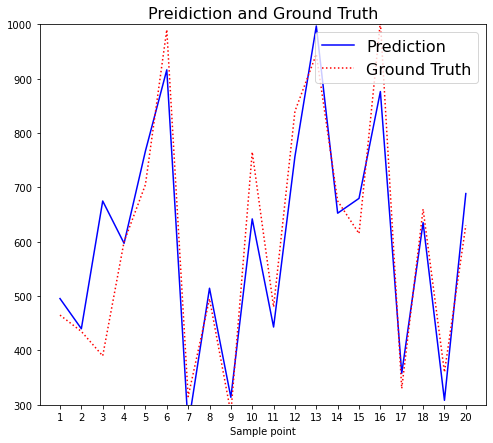

In [23]:
plt.figure(figsize=(8, 7))
x_axis = np.arange(1, 20 + 1, 1)

plt.plot(x_axis, y_pred_unstandardize[0:20], label='Prediction', color = 'b', linestyle = "-")
plt.plot(x_axis, y_actual_unstandardize[0:20], label='Ground Truth', color = 'r', linestyle = ":")

plt.ylim(300, 1000)
plt.xticks(range(1, 21))
plt.title('Preidiction and Ground Truth', fontsize=16)
plt.xlabel('Sample point')
plt.legend(loc='best', fontsize=16)
plt.show()

In [21]:
# Train ERROR
y_pred = rf_regressor.predict(df_features.iloc[:60000,:-1])
y_pred_unstandardize = np.array(unstandardize_data(y_pred, time_mean, time_std))
y_actual_unstandardize = np.array(unstandardize_data(df_features.iloc[:60000,-1], time_mean, time_std))
print("train RMSE:", np.round(np.sqrt(np.mean((y_actual_unstandardize - y_pred_unstandardize)**2)), 3))

# VALID ERROR
y_pred = rf_regressor.predict(df_features_valid.iloc[:,:-1])
y_pred_unstandardize = np.array(unstandardize_data(y_pred, time_mean, time_std))
y_actual_unstandardize = np.array(unstandardize_data(df_features_valid.iloc[:,-1], time_mean, time_std))
print("valid RMSE:", np.round(np.sqrt(np.mean((y_actual_unstandardize - y_pred_unstandardize)**2)), 3))

train RMSE: 552.493
valid RMSE: 886.28


In [15]:
filename = 'final/submit_rf0.csv'

y_pred_test = rf_regressor.predict(df_features_test)
predict_lst = np.array(unstandardize_data(y_pred_test, time_mean, time_std))
result = []
for i in predict_lst:
    result.append(i)
submit = pd.read_csv("dataset/sampleSubmission.csv")
submit['TRAVEL_TIME'] = result
submit.to_csv(filename, sep=',', index = False)